In [1]:
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import logging
import numpy as np
import torchvision 
import random,math
import torchvision.transforms.functional as TF
import torchvision.transforms as T
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from operator import attrgetter
from functools import partial
from torch.utils.data import DataLoader,default_collate,Dataset
from copy import copy
from torch.optim.lr_scheduler import ExponentialLR
from collections.abc import Mapping
from diffusers import UNet2DModel
from torch.optim.lr_scheduler import ExponentialLR
mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

In [2]:
# Get the device
def_device = 'cuda' if torch.cuda.is_available() else 'cpu'


# Function to send data to device
def to_device(x, device=def_device):
    if isinstance(x, torch.Tensor): return x.to(device)
    if isinstance(x, Mapping): return {k:v.to(device) for k,v in x.items()}
    return type(x)(to_device(o, device) for o in x)

def to_cpu(x):
    if isinstance(x, Mapping): return {k:to_cpu(v) for k,v in x.items()}
    if isinstance(x, list): return [to_cpu(o) for o in x]
    if isinstance(x, tuple): return tuple(to_cpu(list(x)))
    res = x.detach().cpu()
    return res.float() if res.dtype==torch.float16 else res

In [3]:
# Load the datasets
# Remember to pad the images with 2 pixels on each side i.e. to make the image size 32x32

batch_size = 1024

transforms = T.Compose([T.ToTensor(),T.Pad(2),lambda x: x- 0.5])

train_ds = torchvision.datasets.FashionMNIST(root = './data/train',train = True,download = True,transform = transforms)
valid_ds = torchvision.datasets.FashionMNIST(root = './data/valid',train = False,download = True,transform = transforms)

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=4)

In [4]:
def add_noise(x_0, alphabar, n_steps=1000):
    device = x_0.device
    n = len(x_0)
    timesteps = torch.randint(0, n_steps, (n,), device=device)
    alphabar_t = alphabar[timesteps].reshape(-1, 1, 1, 1).to(device)
    noise = torch.randn_like(x_0, device=device)
    x_t = x_0 * alphabar_t.sqrt() + (1. - alphabar_t).sqrt()* noise
    return (x_t, timesteps.to(device)), noise

In [5]:
beta_min = 0.0001
beta_max = 0.02
n_steps = 1000
beta = torch.linspace(beta_min, beta_max, n_steps)
alpha = 1. - beta
alphabar = alpha.cumprod(dim=0)
sigma = beta.sqrt()

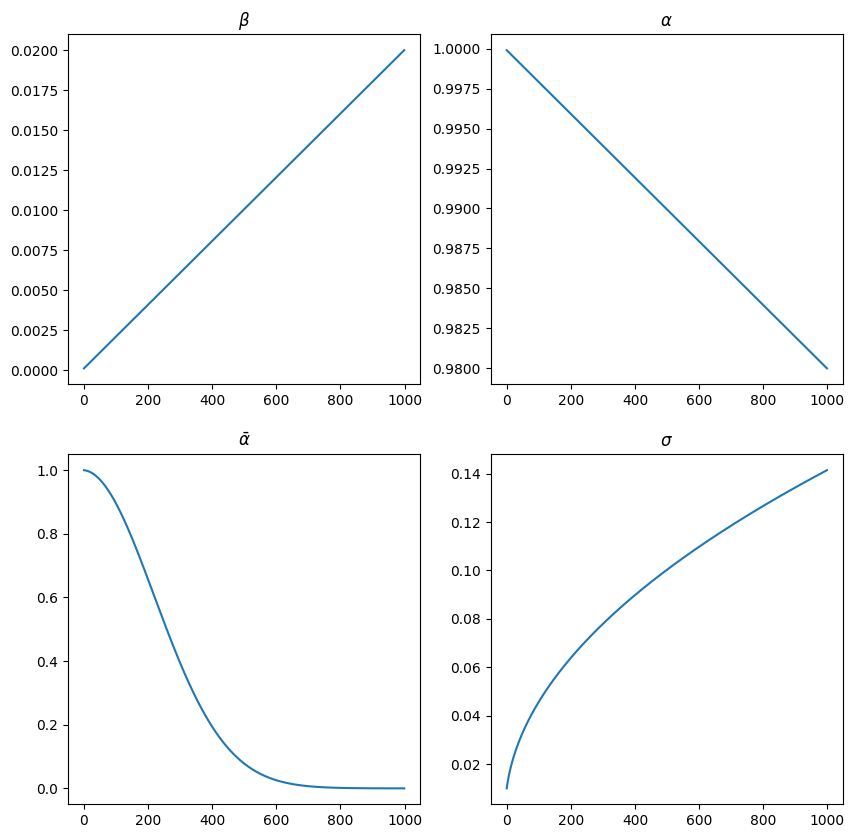

In [6]:
fig, ax = plt.subplots(2,2, figsize=(10,10))
ax[0,0].plot(beta)
ax[0,0].set_title(r'$\beta$')
ax[0,1].plot(alpha)
ax[0,1].set_title(r'$\alpha$')
ax[1,0].plot(alphabar)
ax[1,0].set_title(r'$\bar{\alpha}$')
ax[1,1].plot(sigma)
ax[1,1].set_title(r'$\sigma$')
plt.show()

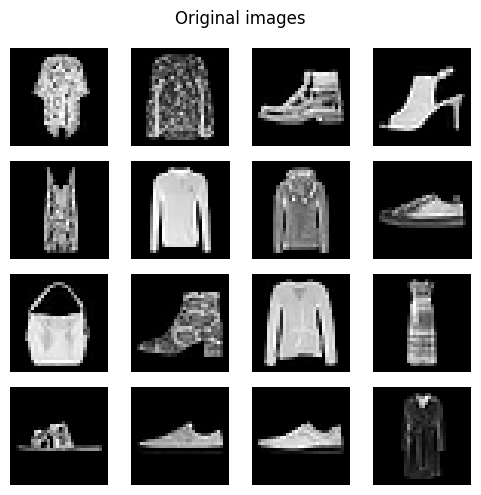

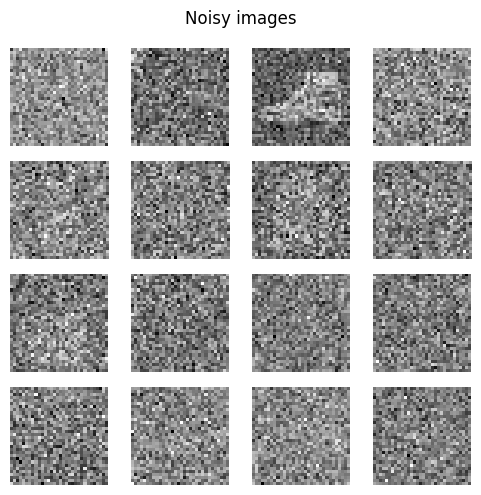

tensor([892, 954,  93, 850, 297, 935, 211, 464, 284, 789, 695, 498, 816, 494,
        669, 715])


In [7]:
batch = next(iter(train_dl))
x_0 = batch[0][:16]
(x_t, timesteps), noise = add_noise(x_0, alphabar)

plt.figure(figsize=(5, 5))
plt.suptitle('Original images')
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_0[i, 0], cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 5))
plt.suptitle('Noisy images')
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_t[i, 0], cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

print(timesteps)

In [8]:
def abar(t, T): return (t/T*math.pi/2).cos()**2

n_steps = 1000
timesteps = torch.linspace(0, n_steps -1 , n_steps)
alphabar = abar(timesteps, n_steps)
alpha = alphabar/abar(timesteps-1, n_steps)
beta = (1.0 - alpha).clamp(0.0001, 0.9999)
sigma = beta.sqrt()

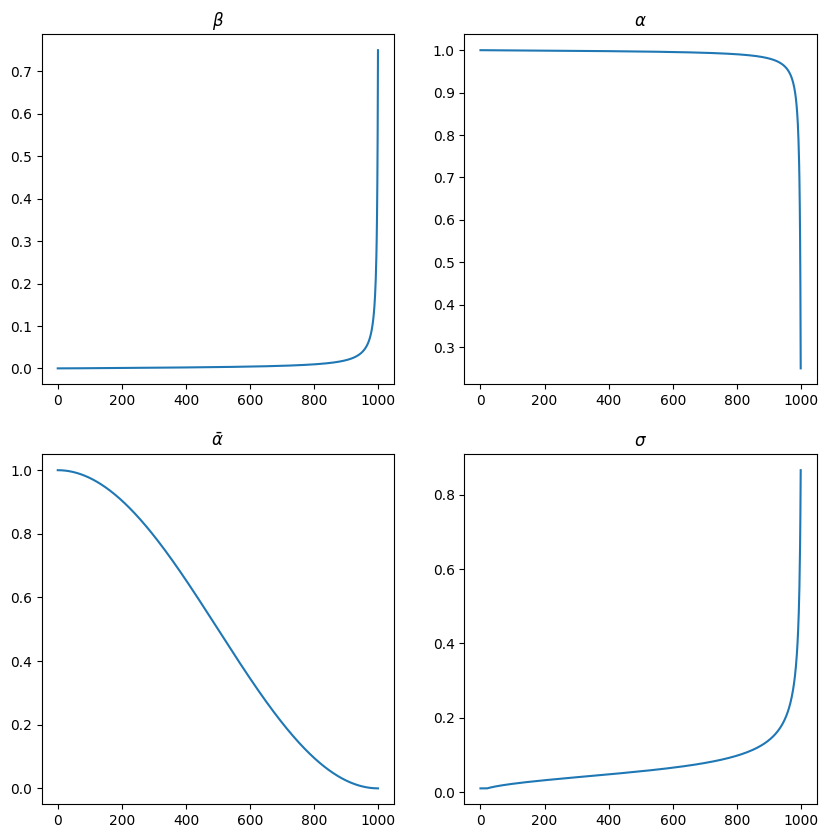

In [9]:
fig, ax = plt.subplots(2,2, figsize=(10,10))
ax[0,0].plot(beta)
ax[0,0].set_title(r'$\beta$')
ax[0,1].plot(alpha)
ax[0,1].set_title(r'$\alpha$')
ax[1,0].plot(alphabar)
ax[1,0].set_title(r'$\bar{\alpha}$')
ax[1,1].plot(sigma)
ax[1,1].set_title(r'$\sigma$')
plt.show()

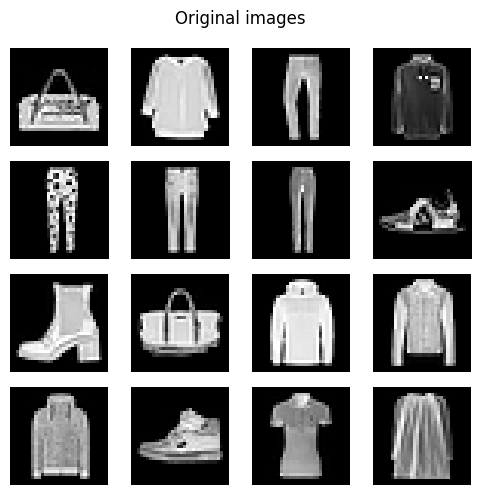

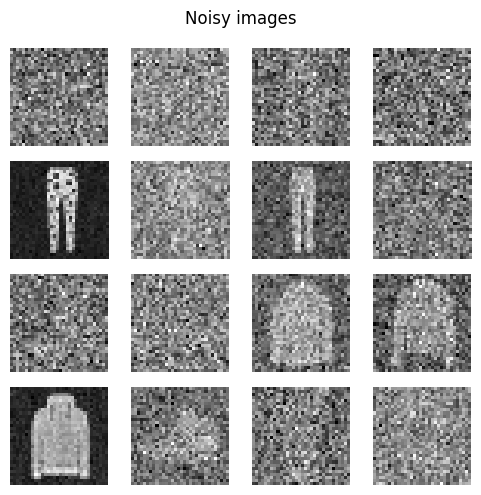

tensor([771, 975, 503, 932,  29, 502, 111, 673, 622, 866, 273, 287,  37, 298,
        611, 675])


In [10]:
batch = next(iter(train_dl))
x_0 = batch[0][:16]
(x_t, timesteps), noise = add_noise(x_0, alphabar)

plt.figure(figsize=(5, 5))
plt.suptitle('Original images')
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_0[i, 0] + 0.5, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 5))
plt.suptitle('Noisy images')
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_t[i, 0] + 0.5, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

print(timesteps)

In [11]:
class DDPM_model(nn.Module):
    def __init__(self, model, beta_min = 0.0001, beta_max = 0.02, n_steps = 1000, cosine_schedule = False):
        super().__init__()
        self.model = model
        self.beta_min = beta_min
        self.beta_max = beta_max
        self.n_steps = n_steps
        if cosine_schedule:
            def abar(t, T): return (t/T*math.pi/2).cos()**2
            timesteps = torch.linspace(0, self.n_steps - 1, self.n_steps)
            self.alphabar = abar(timesteps, self.n_steps)
            self.alpha = self.alphabar/abar(timesteps-1, self.n_steps)
            self.beta = (1. - self.alpha).clamp(0,1)
            self.sigma = self.beta.sqrt()
        else:
            self.beta = torch.linspace(beta_min, beta_max, self.n_steps)
            self.alpha = 1. - self.beta
            self.alphabar = self.alpha.cumprod(dim=0)
            self.sigma = self.beta.sqrt()

    def add_noise(self, x_0):
        device = x_0.device
        n = len(x_0)
        timesteps = torch.randint(0, self.n_steps, (n,), device=device)
        alphabar_t = self.alphabar.to(device)[timesteps].reshape(-1, 1, 1, 1)
        noise = torch.randn_like(x_0, device=device)
        x_t = x_0 * alphabar_t.sqrt() + (1. - alphabar_t).sqrt()* noise
        return (x_t, timesteps.to(device)), noise

    def forward(self, x):
        return self.model.forward(*x).sample
    
    @torch.no_grad()
    def sample(self,sz):
        device = next(self.model.parameters()).device
        x_t = torch.randn(sz, device=device)
        preds = []
        self.model.eval()
        for t in reversed(range(self.n_steps)):
            t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
            z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
            alpha_t = self.alpha[t].to(device)
            alphabar_t = self.alphabar[t].to(device)
            noise = self.model(x_t, t_batch).sample.to(device)
            eps_coef = (1 - alpha_t) / (1 - alphabar_t) ** .5
            mean = 1 / (alpha_t ** 0.5) * (x_t - eps_coef * noise)
            x_t = mean + self.sigma[t] * z
            preds.append(x_t.float().cpu())
        return preds
    
    @torch.no_grad()
    def sample_skip(self, sz):
        ps = next(self.model.parameters()).device
        x_t = torch.randn(sz).to(ps)
        preds = []
        self.model.eval()
        for t in reversed(range(self.n_steps)):
            t_batch = torch.full((x_t.shape[0],), t, device=ps, dtype=torch.long)
            z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(ps)
            alpha_t = self.alpha[t].to(ps)
            alphabar_t = self.alphabar[t].to(ps)
            if t%3==0 or t<50: noise = self.model(x_t, t_batch).sample.to(ps)
            eps_coef = (1 - alpha_t) / (1 - alphabar_t) ** .5
            mean = 1 / (alpha_t ** 0.5) * (x_t - eps_coef * noise)
            x_t = mean + self.sigma[t] * z
            preds.append(x_t.float().cpu())
        return preds
    
    @torch.no_grad()
    def sample_skip_2(self,sz):
        ps = next(self.model.parameters()).device
        x_t = torch.randn(sz).to(ps)
        sample_at = {t for t in range(self.n_steps) if (t+101)%((t+101)//100)==0}
        preds = []
        self.model.eval()
        for t in reversed(range(self.n_steps)):
            t_batch = torch.full((x_t.shape[0],), t, device=ps, dtype=torch.long)
            z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(ps)
            alpha_t = self.alpha[t].to(ps)
            alphabar_t = self.alphabar[t].to(ps)
            if t in sample_at: noise = self.model(x_t, t_batch).sample.to(ps)
            eps_coef = (1 - alpha_t) / (1 - alphabar_t) ** .5
            mean = 1 / (alpha_t ** 0.5) * (x_t - eps_coef * noise)
            x_t = mean + self.sigma[t] * z
            if t in sample_at: preds.append(x_t.float().cpu())
        return preds

In [12]:
unet_model = UNet2DModel(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 256),norm_num_groups=8)
model = DDPM_model(unet_model, 0.0001, 0.02, 1000, cosine_schedule=True)

In [13]:
epochs = 5
lr = 0.001
opt = optim.Adam(model.parameters(), lr=lr,eps = 1e-5)
sched = optim.lr_scheduler.OneCycleLR(opt, lr, epochs=epochs, steps_per_epoch=len(train_dl))

In [14]:
def fit(model,train_dl,valid_dl,loss_func,epochs,opt,sched):
    scaler = torch.cuda.amp.GradScaler()
    for epoch in range(epochs):
        losses = []
        model.train()
        for xb,_ in train_dl:
            opt.zero_grad()
            xb = to_device(xb)
            (x_t, timesteps), noise = model.add_noise(xb)
            (x_t, timesteps) = to_device((x_t, timesteps))
            noise = to_device(noise)
            with torch.cuda.amp.autocast(dtype=torch.float16):
                preds = model((x_t, timesteps))
                loss = loss_func(preds, noise)
            losses.append(loss.item() * len(xb))
            scaler.scale(loss).backward()
            scaler.step(opt)
            sched.step()
            scaler.update()
        print(f"Epoch {epoch} train loss: {sum(losses)/len(train_ds)}")
        model.eval()
        losses = []
        with torch.no_grad():
            for xb,_ in valid_dl:
                xb = to_device(xb)
                (x_t, timesteps), noise = model.add_noise(xb)
                (x_t, timesteps) = to_device((x_t, timesteps))
                noise = to_device(noise)
                preds = model((x_t, timesteps))
                loss = loss_func(preds, noise)
                losses.append(loss.item() * len(xb))
        print(f"Epoch {epoch} valid loss: {sum(losses)/len(valid_ds)}")

In [15]:
# fit(model.to(def_device),train_dl,valid_dl,F.mse_loss,epochs,opt,sched)

In [16]:
# model = model.cpu()
# torch.save(model.state_dict(),"DDPM_state_dict.pth")
# torch.save(model,"DDPM.pth")
# torch.save(model.model,"DDPM_unet.pth")
# torch.save(model.model.state_dict(),"DDPM_unet_state_dict.pth")

In [17]:
model = DDPM_model(unet_model, 0.0001, 0.02, 1000, cosine_schedule=True)
model.load_state_dict(torch.load("DDPM_cosine_state_dict.pth",map_location=torch.device('cpu')))

<All keys matched successfully>

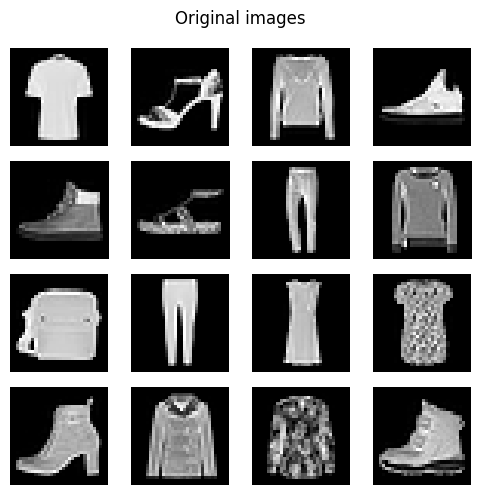

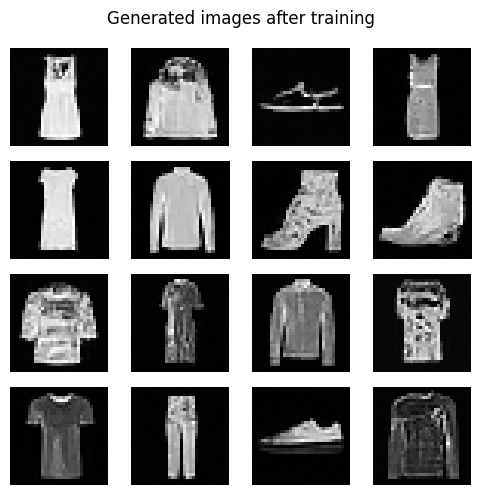

In [18]:
batch = next(iter(train_dl))
x_0 = batch[0][:16] + 0.5

plt.figure(figsize=(5, 5))
plt.suptitle('Original images')
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_0[i, 0]+ 0.5, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

preds = model.sample((16,1,32,32))

plt.figure(figsize=(5, 5))
plt.suptitle("Generated images after training")
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(preds[-2][i, 0]+ 0.5, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

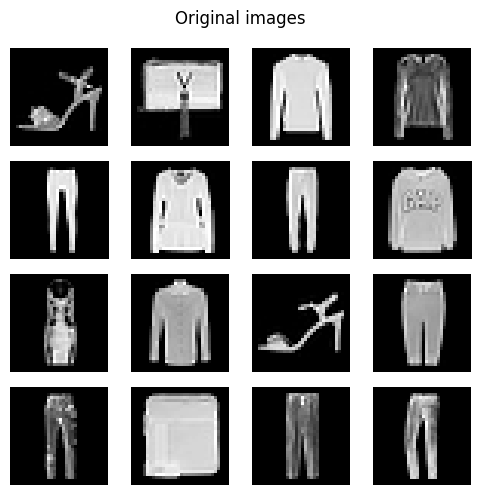

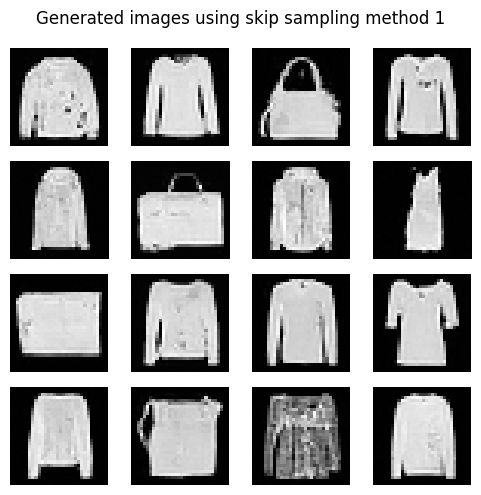

In [19]:
batch = next(iter(train_dl))
x_0 = batch[0][:16]

plt.figure(figsize=(5, 5))
plt.suptitle('Original images')
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_0[i, 0], cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

preds = model.sample_skip((16,1,32,32))

plt.figure(figsize=(5, 5))
plt.suptitle("Generated images using skip sampling method 1")
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(preds[-2][i, 0]+ 0.5, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

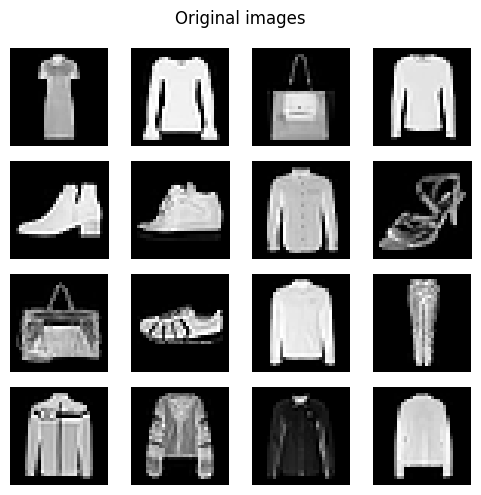

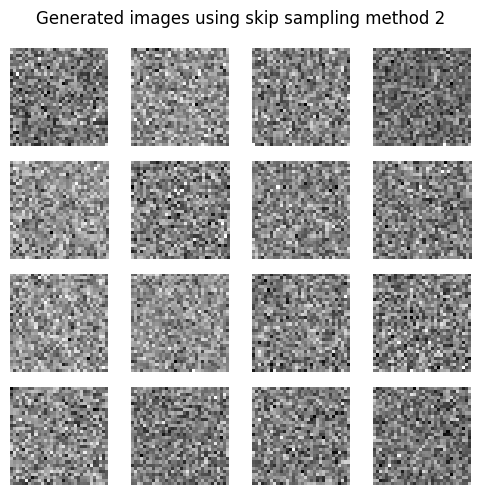

In [20]:
batch = next(iter(train_dl))
x_0 = batch[0][:16]

plt.figure(figsize=(5, 5))
plt.suptitle('Original images')
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_0[i, 0], cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

preds = model.sample_skip_2((16,1,32,32))

plt.figure(figsize=(5, 5))
plt.suptitle("Generated images using skip sampling method 2")
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(preds[-2][i, 0]+ 0.5, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [21]:
%matplotlib inline
import matplotlib.animation as animation
from IPython.display import display, HTML

def get_images(preds, num , l):
    return [preds[i][num][0] + 0.5 for i in l]

def animate(images):
    fig = plt.figure(figsize=(3, 3))
    plt.axis("off")
    ims = [[plt.imshow(image, animated=True, cmap='gray')] for i, image in enumerate(images)]
    plt.close()
    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=3000)
    display(HTML(ani.to_html5_video()))

In [22]:
preds = model.sample((16,1,32,32))
num = random.randint(0, preds[0].shape[0]-1)
l = list(range(800,990, 5))+list(range(990,999))+[998]*10
images = get_images(preds,num,l)
animate(images)

In [23]:
preds = model.sample_skip((16,1,32,32))
num = random.randint(0, preds[0].shape[0]-1)
l = list(range(len(preds)))
l = [i for i in l if i%50==0 or i > len(preds)-50] + [len(preds)-2]*10
images = get_images(preds,num,l)
animate(images)

In [24]:
preds = model.sample_skip_2((16,1,32,32))
num = random.randint(0, preds[0].shape[0]-1)
l = list(range(len(preds)))
l = [i for i in l if i%50==0 or i > len(preds)-50] + [len(preds)-2]*10
images = get_images(preds,num,l)
animate(images)